In [1]:
import numpy as np
from scipy.spatial import distance
import scipy.integrate as integrate
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [182]:
class Run:
    
    def __init__(self, f=0, sigma=0.2, eps=0.005, x0=[0.1,0.1]):
        self.f      = 0.0
        self.sigma  = 0.2
        self.A      = np.array([[(1-self.f)**-1, 0],[0, 1-self.f]])
        self.n_min  = 1e-6
        self.n_init = 1e-6
        
        self.mu     = 2e-7*100
        self.eps    = 5e-3
        
        self.grid_fineness = 5
        
        self.tick      = 0
        self.tau       = 100
        self.points    = set()
        self.history   = {}
        
        self.n = np.array([self.n_init])
        self.x = np.array([x0])
        
        self.generate_b_vector_and_a_matrix()
    
    def generate_nearby_point(self, x):
        random_point = (np.random.random(x.shape) * 2 - 1) * self.eps
        
        if np.linalg.norm(random_point) > self.eps:
            return self.generate_nearby_point(x)
        
        return x + random_point.round(self.grid_fineness)
    
    def generate_b_vector_and_a_matrix(self):
        self.b = 1 - np.einsum("ik, kl, il->i", self.x, self.A, self.x)
        
        dist2  = distance.squareform(distance.pdist(self.x, "sqeuclidean"))
        self.a = np.exp(-dist2 / (2 * self.sigma**2))
    
    def get_derivative(self, n, t):
        I = np.dot(self.a, n)
        return (self.b - I) * n
    
    def mutate(self):
        new_species = False
        
        chances = self.mu * self.b * self.n * 100
        randoms = np.random.random(chances.shape)
        
        mutation_indices = np.where(randoms < chances)[0]
        
        for ind in mutation_indices:
            self.n[ind] -= self.n_init
            new_pos = self.generate_nearby_point(self.x[ind])
            self.x = np.vstack((self.x, new_pos))#check
            self.n = np.hstack((self.n, self.n_init))#check
            
            new_species = True
            self.points.add(tuple(new_pos))
        
        if new_species:
            self.generate_b_vector_and_a_matrix()
    
    def die_out(self):
        keep_indices = self.n >= self.n_min
        
        if not np.all(keep_indices):
            self.n = self.n[keep_indices]
            self.x = self.x[keep_indices]
            
            self.generate_b_vector_and_a_matrix()
    
    def log_state(self):
        if self.tick % 100 == 0:
            self.history[self.tick] = np.copy(self.x)
    
    def step(self):
        result_vector = integrate.odeint(self.get_derivative, self.n, [self.tick, self.tick+self.tau])
        self.n = result_vector[-1]
        
        self.die_out()
        self.mutate()
        
        self.log_state()
        
        self.tick += 1

In [199]:
%%time
r = Run()
for _ in range(100000):
    r.step()

print(r.x)
print(r.n)

[[-0.00025  0.09819]
 [ 0.09203 -0.00502]]
[0.55184929 0.55723105]
CPU times: user 25.7 s, sys: 31.5 ms, total: 25.7 s
Wall time: 25.6 s


<IPython.core.display.Javascript object>


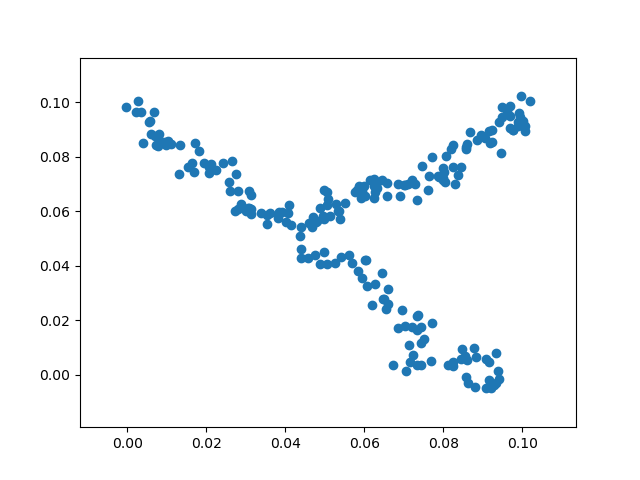

In [200]:
points = np.array([list(x) for x in r.points])
plt.figure()
plt.scatter(points[:, 0], points[:, 1]);

<IPython.core.display.Javascript object>


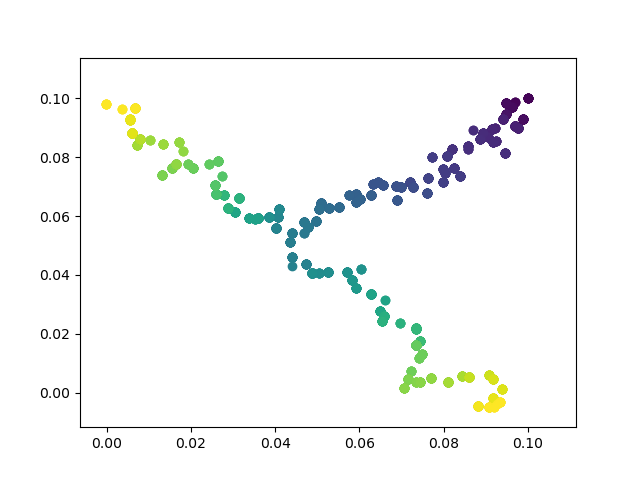

In [203]:
plt.figure()
cmap = plt.get_cmap("viridis")

max_time = max(r.history.keys())

for time, x in r.history.items():
    plt.scatter(x[:,0], x[:,1], color=cmap(time/max_time))

<IPython.core.display.Javascript object>


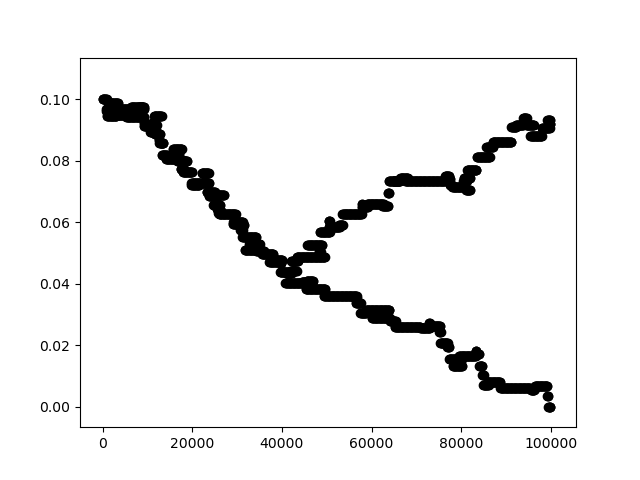

In [207]:
plt.figure()

for time, x in r.history.items():
    plt.scatter(np.ones_like(x[:,0]) * time, x[:,0], color="black")

In [171]:
asd = np.zeros((100,100))
f   = 0.01
A   = np.array([[(1-f)**-1, 0],[0, 1-f]])

for i, x in enumerate(np.linspace(-1, 1, 100)):
    for j, y in enumerate(np.linspace(-1, 1, 100)):
        X = np.array([x,y])
        asd[i, j] = 1 - np.dot(X, np.dot(A, X))

<IPython.core.display.Javascript object>


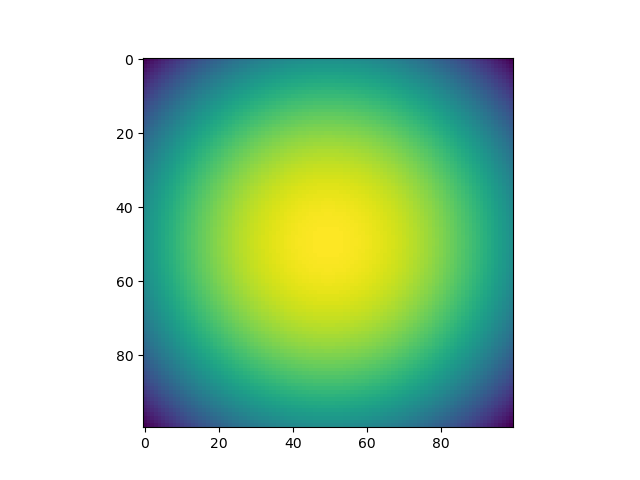

In [172]:
plt.figure()
plt.imshow(asd)

In [173]:
%matplotlib notebook

<IPython.core.display.Javascript object>


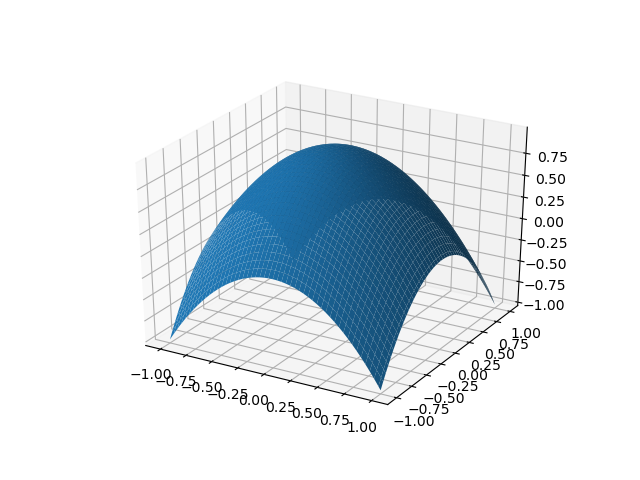

In [174]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

grids = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
ax.plot_surface(grids[0], grids[1], asd)

In [161]:
%%time
bloeh = Run()
for _ in range(1000000):
    bloeh.step()

print(bloeh.x)
print(bloeh.n)

[[-5.5673e-01  1.1423e-01]
 [-1.6438e-01  1.7610e-01]
 [-2.2400e-03 -6.3255e-01]
 [ 2.1739e-01  5.5840e-01]
 [ 5.1171e-01 -2.3480e-01]
 [-2.6453e-01  5.0312e-01]
 [ 1.6404e-01  1.4296e-01]
 [ 1.6443e-01  1.4783e-01]
 [-1.8358e-01  1.5952e-01]
 [ 4.3385e-01  1.5664e-01]
 [-5.0043e-01 -2.9086e-01]
 [-1.0795e-01  5.4492e-01]
 [-5.6046e-01  1.1726e-01]
 [ 1.3992e-01 -3.0019e-01]
 [-5.4167e-01  1.6114e-01]
 [-1.9400e-03 -6.3315e-01]
 [-1.2860e-02 -6.2360e-01]
 [-7.0990e-02 -1.0350e-01]
 [ 4.8795e-01 -3.1312e-01]
 [ 2.9000e-04 -6.3566e-01]
 [-3.3543e-01 -3.5317e-01]
 [ 3.1169e-01  5.0864e-01]
 [ 6.1000e-04 -6.3340e-01]]
[1.91614517e-01 1.11182307e-01 3.66057782e-02 2.55130332e-01
 2.89828014e-01 3.26744577e-01 4.15346289e-01 2.34237205e-04
 3.47939956e-01 4.80096305e-01 3.18263339e-01 2.60600390e-01
 1.23557001e-01 4.69674914e-01 2.08916079e-01 5.34624293e-04
 2.66433806e-01 4.20693196e-01 2.45336670e-01 1.50562128e-01
 3.64975340e-01 2.39032377e-01 3.23124506e-06]
CPU times: user 7min 16s, 

<IPython.core.display.Javascript object>


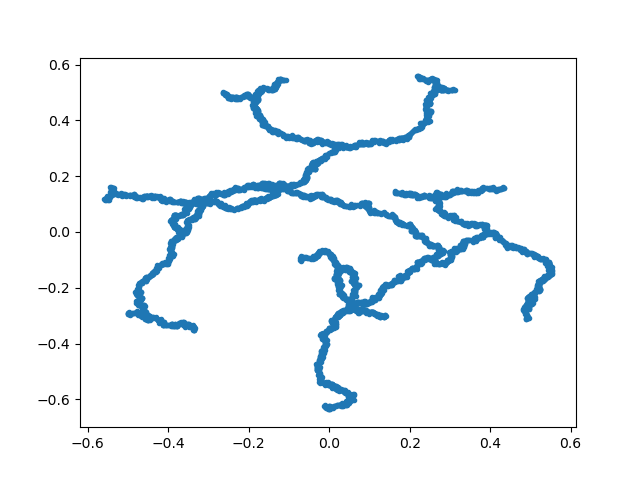

In [167]:
points = np.array([list(x) for x in bloeh.points])
plt.figure()
plt.scatter(points[:, 0], points[:, 1], marker=".");